In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [22]:
df['marketing_channel_cleaned'].value_counts()

marketing_channel_cleaned
direct          17434
email            3256
affiliate         721
social media      323
unknown           130
Name: count, dtype: int64

In [10]:

# Ensure datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])
df = df.sort_values('purchase_ts_cleaned')

# Create monthly cohort
df['year_month'] = df['purchase_ts_cleaned'].dt.to_period('M')

# Step 1: Identify each user's first purchase month
if 'first_purchase_month' in df.columns:
    df = df.drop(columns=['first_purchase_month'])

first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .rename('first_purchase_month')
    .reset_index()
)

df = df.merge(first_purchase, on='user_id', how='left')

# Step 2: Filter only new customers (first purchase in that month)
new_customers = df[df['year_month'] == df['first_purchase_month']]

# Step 3: Total new customers per month
new_customers_per_month = (
    new_customers.groupby('year_month')['user_id']
    .nunique()
    .rename('new_customers')
)

# Step 4: Channel contribution per month
channel_contrib = (
    new_customers.groupby(['year_month', 'marketing_channel_cleaned'])['user_id']
    .nunique()
    .reset_index(name='channel_customers')
)

# Step 5: Compute contribution percentage
channel_contrib['contribution_pct'] = (
    channel_contrib.groupby('year_month')['channel_customers']
    .transform(lambda x: (x / x.sum()) * 100)
)

# Step 6: Calculate channel metrics
# Actual number of active channels per month
active_channels = (
    channel_contrib.groupby('year_month')['marketing_channel_cleaned']
    .count()
    .rename('active_channels')
)

# Effective channels (diversity-weighted)
effective_channels = (
    channel_contrib.groupby('year_month')['contribution_pct']
    .apply(lambda x: 1 / ((x/100)**2).sum())
    .rename('effective_channels')
)

# Direct channel dominance (% from Direct)
direct_dominance = (
    channel_contrib[channel_contrib['marketing_channel_cleaned'] == 'direct']
    .set_index('year_month')['contribution_pct']
    .rename('direct_pct')
)

# Step 7: Merge all metrics
cae_analysis = pd.concat([
    new_customers_per_month,
    active_channels,
    effective_channels,
    direct_dominance
], axis=1).reset_index()

# Fill NaN for months without 'direct' channel
cae_analysis['direct_pct'] = cae_analysis['direct_pct'].fillna(0)

# Calculate CAE per active channel (not weighted by diversity)
cae_analysis['CAE_per_channel'] = (
    cae_analysis['new_customers'] / cae_analysis['active_channels']
)


In [11]:
cae_analysis

,year_month,new_customers,active_channels,effective_channels,direct_pct,CAE_per_channel
0,2019-01,419,5,1.433303,82.816229,83.80
1,2019-02,318,4,1.531532,79.559748,79.50
2,2019-03,514,4,1.429740,82.879377,128.50
3,2019-04,522,4,1.342034,85.823755,130.50
4,2019-05,495,4,1.407049,83.434343,123.75
5,2019-06,467,4,1.350271,85.438972,116.75
6,2019-07,497,5,1.537206,79.275654,99.40
7,2019-08,514,4,1.427192,82.879377,128.50
8,2019-09,568,4,1.405218,83.450704,142.00
9,2019-10,479,4,1.409646,83.507307,119.75


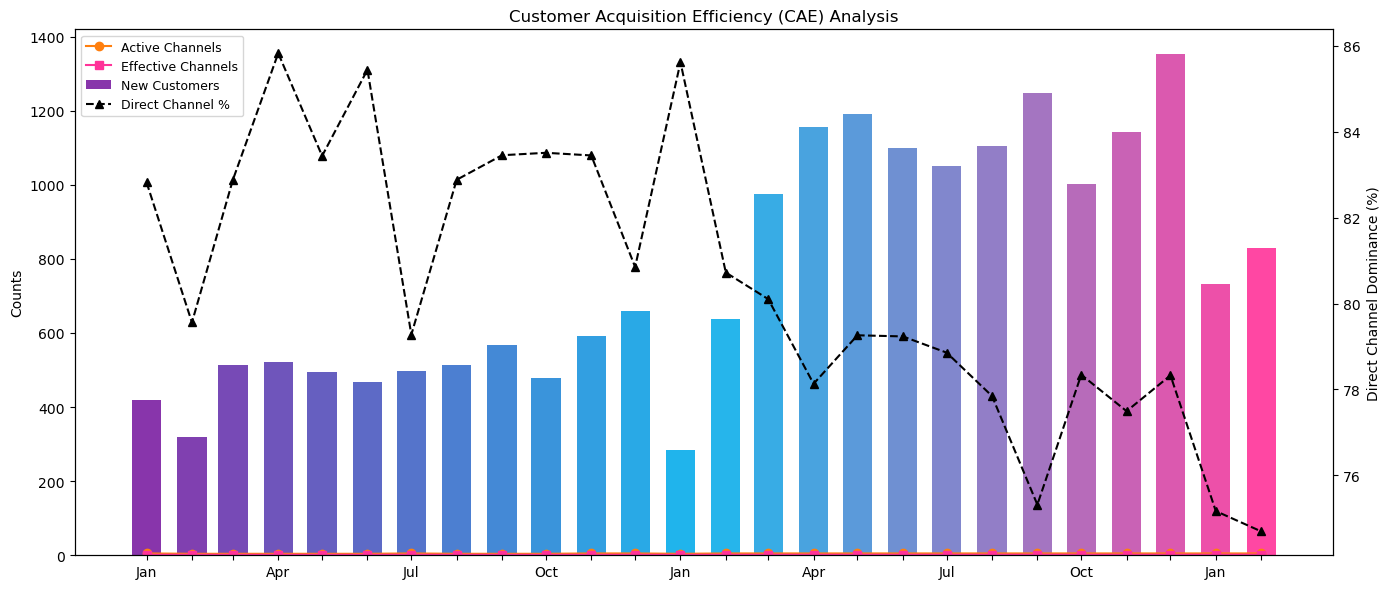

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

# Ensure datetime
cae_analysis['year_month_dt'] = pd.to_datetime(cae_analysis['year_month'].astype(str))

# X-axis labels: only first month of each quarter
def quarter_month_label(dt):
    if dt.month in [1, 4, 7, 10]:
        return dt.strftime('%b')
    else:
        return ''

x_labels = cae_analysis['year_month_dt'].apply(quarter_month_label)

fig, ax1 = plt.subplots(figsize=(14,6))

# Gradient colors for bars
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", colors)

# Normalize bar colors across the dataset
norm = mcolors.Normalize(vmin=0, vmax=len(cae_analysis)-1)
bar_colors = [cmap(norm(i)) for i in range(len(cae_analysis))]

# Bar chart for new customers with gradient
ax1.bar(cae_analysis['year_month_dt'], cae_analysis['new_customers'], color=bar_colors, alpha=0.9, label='New Customers', width=20)

# Line charts
ax1.plot(cae_analysis['year_month_dt'], cae_analysis['active_channels'], color="#FF7F0E", marker='o', label='Active Channels')   # Orange
ax1.plot(cae_analysis['year_month_dt'], cae_analysis['effective_channels'], color="#FF3399", marker='s', label='Effective Channels') # Pink

# Remove x-axis title
ax1.set_xlabel('')
ax1.set_ylabel('Counts')
ax1.set_title('Customer Acquisition Efficiency (CAE) Analysis')
ax1.grid(False)

# Set x-ticks and labels (horizontal)
ax1.set_xticks(cae_analysis['year_month_dt'])
ax1.set_xticklabels(x_labels)

# Secondary axis for Direct channel dominance (black)
ax2 = ax1.twinx()
ax2.plot(cae_analysis['year_month_dt'], cae_analysis['direct_pct'], color='black', marker='^', linestyle='--', label='Direct Channel %')
ax2.set_ylabel('Direct Channel Dominance (%)')

# Combine legends with smaller font
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()
